### Libraries

In [83]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numpy.random import default_rng
#from random import random.seed,gauss


# multivariate lstm example
from numpy import array
from numpy import hstack
import torch
import torch.nn as nn
import torch.optim as optim  # Import optim module


### Parameters

In [84]:
##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=120.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 1.4e-2

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

# generate Gaussian random numbers at step dt and then interpolate for integrator
rng = np.random.default_rng(seed=1)

# width of the Gaussian distribution
width=1.

xran=rng.normal(0.,width,maxtime_pts+1)
yran=rng.normal(0.,width,maxtime_pts+1)
zran=rng.normal(0.,width,maxtime_pts+1)
xran_i = interp1d(t_eval,xran)
yran_i = interp1d(t_eval,yran)
zran_i = interp1d(t_eval,zran)

lorenz_soln_nf=np.zeros((d,maxtime_pts+1))

In [85]:
print(maxtime_pts)

5400


### Lorenz 63

In [86]:
##
## Lorenz '63
##

sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):

  dy0 = sigma * (y[1] - y[0])
  dy1 = y[0] * (rho - y[2]) - y[1]
  dy2 = y[0] * y[1] - beta * y[2]

  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]


### Solution of Lorenz 63

In [87]:

# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0:d,:])

### Split the Sequence

[[17.67715816 15.77695495 12.83202575  9.49915688  6.31667148]
 [12.93137919  5.68211629 -0.14898817 -3.81814923 -5.64699747]
 [43.91404334 44.85194679 42.87695699 39.54693535 36.08397169]
 [ 0.         17.67715816 15.77695495 12.83202575  9.49915688]
 [ 0.         12.93137919  5.68211629 -0.14898817 -3.81814923]
 [ 0.         43.91404334 44.85194679 42.87695699 39.54693535]]


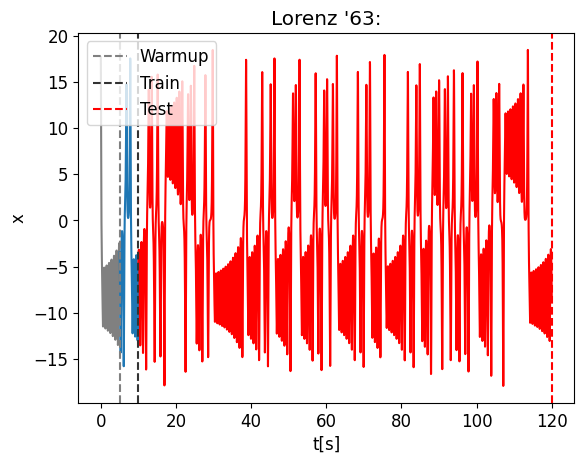

In [88]:
# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

#scaler = StandardScaler()
#x = scaler.fit_transform(x)


print(x[:,0:5])
plt.plot(t_eval[0:warmup_pts+1],x[0,0:warmup_pts+1],"0.5")
plt.plot(t_eval[warmup_pts:traintime_pts+1],x[0,warmup_pts:traintime_pts+1])
plt.plot(t_eval[traintime_pts:testtime_pts],x[0,traintime_pts:testtime_pts], "r")
plt.axvline(x=warmup_pts*dt, ls='--', color='0.5', label='Warmup')
plt.axvline(x=traintime_pts*dt, ls='--', color='0.2', label='Train')
plt.axvline(x=testtime_pts*dt, ls='--', color='r', label='Test')
plt.legend(loc='upper left')

plt.title("Lorenz '63:")
plt.xlabel("t[s]")
plt.ylabel("x")
plt.show()


### Parameters for LSTM

In [101]:
input_size = dlin
sequence_length = 8

num_layers=2
hidden_size=24

learning_rate = 0.001

output_dim = 3
batch_size = 1
#num_epochs = 1000


### Define LSTM

In [102]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :])
        return out

In [103]:
model = LSTMModel(input_size, hidden_size, num_layers, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
x_tensor = torch.tensor(x, dtype=torch.float32)#.reshape(-1, sequence_length, input_size)
x_tensor.to(device)
loss_criterion  = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#x_tensor = x_tensor.reshape(-1,input_size, sequence_length)
#x_tensor.shape
print(x_tensor, x_tensor.shape)
#x_out = torch.zeros(x_tensor.shape).reshape(3,-1)
#x_out.shape

tensor([[17.6772, 15.7770, 12.8320,  ..., -0.2028,  0.1397,  0.4053],
        [12.9314,  5.6821, -0.1490,  ...,  1.3685,  1.3315,  1.3571],
        [43.9140, 44.8519, 42.8770,  ..., 21.6051, 20.2109, 18.9165],
        [ 0.0000, 17.6772, 15.7770,  ..., -0.6616, -0.2028,  0.1397],
        [ 0.0000, 12.9314,  5.6821,  ...,  1.4622,  1.3685,  1.3315],
        [ 0.0000, 43.9140, 44.8519,  ..., 23.1100, 21.6051, 20.2109]]) torch.Size([6, 5400])


### Training the Model

At epoch: 0, loss: 2.203746436582878
At epoch: 10, loss: 0.14913784907181252
At epoch: 20, loss: 0.12660880184746928


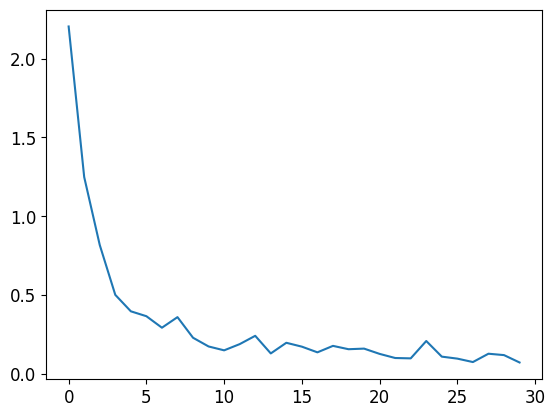

In [104]:
current_loss = 0
num_epochs = 30
loss_hist = []
loss = 0
model.train()

for epoch in range(num_epochs):
    for i in range(traintime_pts - 1):
        index = i + warmup_pts -1
        target = x_tensor[0:d,index+sequence_length]-x_tensor[d:dlin,index+sequence_length]
        data = x_tensor[:,index:index+sequence_length]
        data = data.to(device)
        data = torch.transpose(data, 0, 1)
        target = target.to(device)
        outputs = model(data)
        loss = loss_criterion(outputs[sequence_length-1,:],target)
        current_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch % 10 == 0):
        print(f"At epoch: {epoch}, loss: {current_loss/traintime_pts}")
    loss_hist.append(current_loss/traintime_pts)
    current_loss = 0

plt.plot(loss_hist)
plt.show()

# calculate NRMSE between true Lorenz and training output
#rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
#print('training nrmse: '+str(rms))

### Testing

In [105]:
def evaluate():
    model.eval()
    total_acc, total_count = 0, 0
    predicted = torch.zeros(dlin,testtime_pts).to(device)
    predicted[:,0:sequence_length+1] = x_tensor[:,warmtrain_pts:warmtrain_pts+sequence_length+1]
    with torch.no_grad():
        for i in range(testtime_pts-sequence_length-1):
          xin = predicted[:,i:i+sequence_length]
          output = model(torch.transpose(xin, 0, 1))
          predicted[d:dlin,i+sequence_length+1] = predicted[0:d,i+sequence_length]
          predicted[0:d,i+sequence_length+1] = output[sequence_length-1,:] + predicted[d:dlin,i+sequence_length+1]
          #loss = loss_criterion(predicted[:,i], x_tensor[:,testtime_pts+i])
          total_acc += loss
          #total_count += label.size(0)
    return predicted

xin = torch.zeros(dlin,sequence_length).to(device)
pred = evaluate()

MSE = loss_criterion(x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), pred[0:d,0:lyaptime_pts].cpu())

print(MSE)

#MSE = loss_criterion(x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), torch.tensor(x_test[0:d,0:lyaptime_pts]))

#print(MSE)

# calculate MSE between true Lorenz and prediction for one Lyapunov time
#test_nrmse = np.sqrt(np.mean((x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu().detach().numpy()-pred[0:d,0:lyaptime_pts].cpu().detach().numpy()**2)/total_var))
#print('test nrmse: '+str(test_nrmse))

tensor(79.9715)


In [106]:
#print(d)
print(pred)
plot_pred = np.reshape(pred, [3, -1])
print(plot_pred)
print(plot_pred.shape)
#print(outputs[sequence_length-1,:])

tensor([[ 8.3803, 10.0800, 11.9036,  ...,  6.0227,  6.6026,  7.2819],
        [14.7734, 17.2008, 19.2269,  ..., 10.6448, 12.0833, 13.5948],
        [14.4574, 17.1122, 20.8885,  ..., 15.3987, 15.5745, 16.5158],
        [ 6.8942,  8.3803, 10.0800,  ...,  5.4950,  6.0227,  6.6026],
        [12.3653, 14.7734, 17.2008,  ...,  9.4512, 10.6448, 12.0833],
        [12.7697, 14.4574, 17.1122,  ..., 15.6619, 15.3987, 15.5745]])
tensor([[ 8.3803, 10.0800, 11.9036,  ..., 10.6448, 12.0833, 13.5948],
        [14.4574, 17.1122, 20.8885,  ...,  5.4950,  6.0227,  6.6026],
        [12.3653, 14.7734, 17.2008,  ..., 15.6619, 15.3987, 15.5745]])
torch.Size([3, 9600])


### Plot

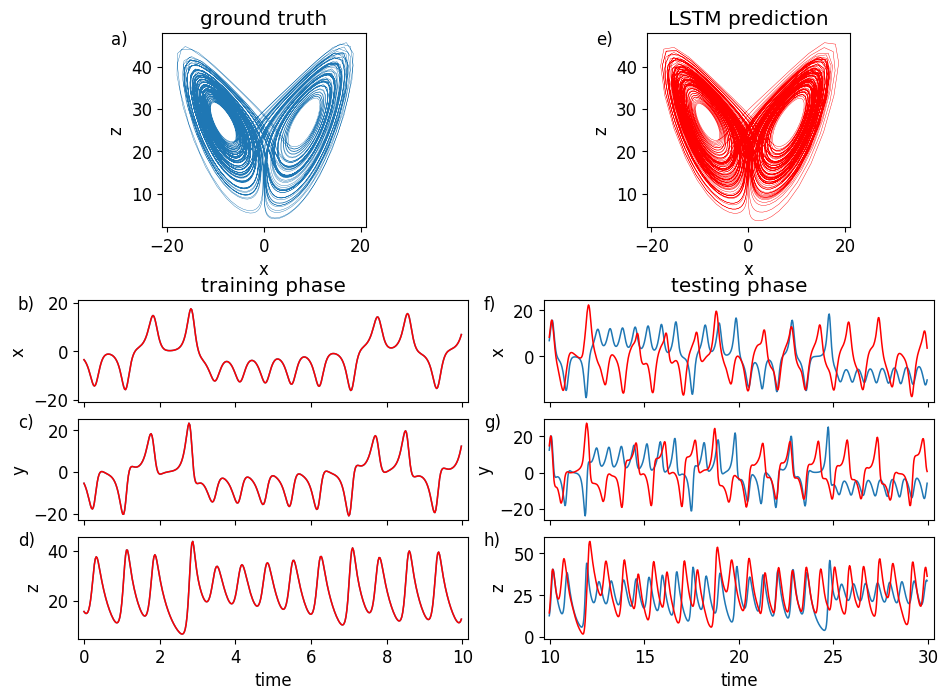

In [107]:

##
## Plot
##



t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38)
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase')
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('LSTM prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

training nrmse: 9.985301397064232e-05
test nrmse: 0.0011178551692191013


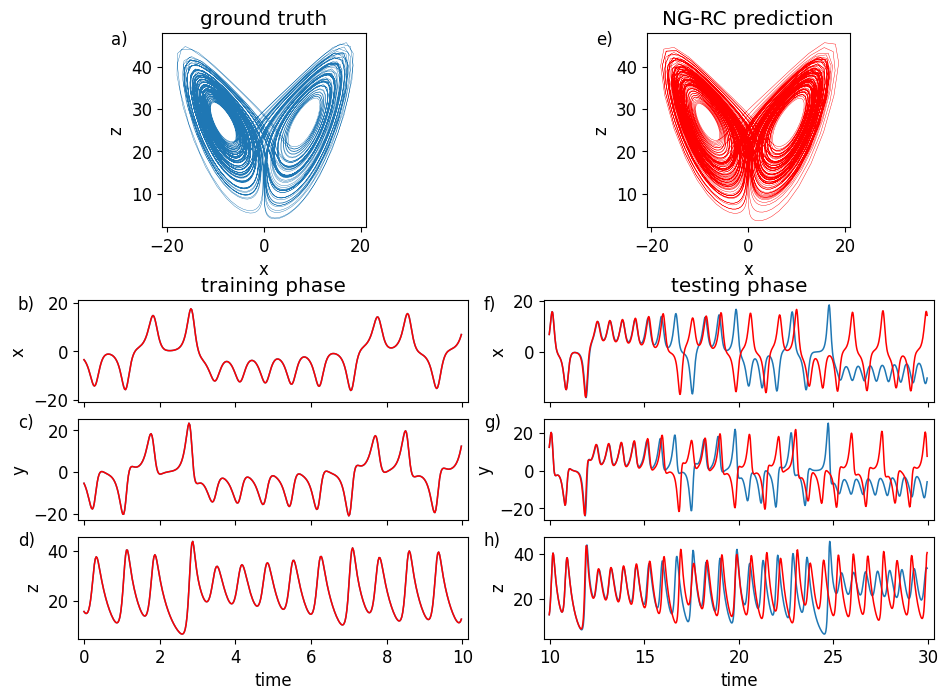

In [95]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20 13:17:10 2021

NVAR with time delays for Lorenz forecasting.  Don't be efficient for now.

@author: Dan
"""

##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=120.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 2.5e-6

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)


##
## NVAR
##
# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

# create an array to hold the full feature vector for training time
# (use ones so the constant term is already 1)
out_train = np.ones((dtot,traintime_pts))

# copy over the linear part (shift over by one to account for constant)
out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

# fill in the non-linear part
cnt=0
for row in range(dlin):
    for column in range(row,dlin):
        # shift by one for constant
        out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
        cnt += 1


# ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

# apply W_out to the training feature vector to get the training output
x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]

# calculate NRMSE between true Lorenz and training output
rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
print('training nrmse: '+str(rms))

# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)              # full feature vector
x_test = np.zeros((dlin,testtime_pts)) # linear part

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

# do prediction
for j in range(testtime_pts-1):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]

# calculate NRMSE between true Lorenz and prediction for one Lyapunov time
test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)
print('test nrmse: '+str(test_nrmse))

##
## Plot
##

t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38)
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase')
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('NG-RC prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

plt.savefig('predict-lorenz.png')
plt.savefig('predict-lorenz.svg')
plt.savefig('predict-lorenz.eps')
plt.savefig('predict-lorenz.pdf')

### Mackey Glass

In [ ]:
N  = 20000

b   = 0.1
c   = 0.2
tau = 17

y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
     1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]

for n in range(17,N+99):
    y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
y = y[100:]

In [ ]:
plt.figure(figsize=(7,4), dpi=150)
plt.plot(y[:2000])